In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

torch.manual_seed(42)
np.random.seed(42)

# 1 Basic Embedding Usage

In [4]:
#simple embedding layer
vocab_size = 10
embedding_dim = 4


embed_layer = nn.Embedding(vocab_size, embedding_dim)

#example input indices
input_indices = torch.LongTensor([1, 2, 4, 5])

#lookup embeddings
output = embed_layer(input_indices)

print (f"Input shape: {input_indices.shape}")
print (f"Output shape: {output.shape}")

print(f"\nInput indices: {input_indices}")
print(f"\nEmbeddings:\n{output}")

assert output.shape == (4, embedding_dim), "Output shape is incorrect"
assert embed_layer.weight.shape == (vocab_size, embedding_dim), "Embedding weight shape is incorrect"

Input shape: torch.Size([4])
Output shape: torch.Size([4, 4])

Input indices: tensor([1, 2, 4, 5])

Embeddings:
tensor([[ 0.6784, -1.2345, -0.0431, -1.6047],
        [-0.7521,  1.6487, -0.3925, -1.4036],
        [ 1.6423, -0.1596, -0.4974,  0.4396],
        [-0.7581,  1.0783,  0.8008,  1.6806]], grad_fn=<EmbeddingBackward0>)


In [5]:
# write function to visualize embeddings
def visualize_embeddings(embeddings, title="Embeddings Heatmap"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(embeddings.detach().numpy(), annot=True, cmap='viridis')
    plt.title(title)
    plt.xlabel('Embedding Dimensions')
    plt.ylabel('Vocabulary Indices')
    plt.show()

## Visualize all embeddings initialized

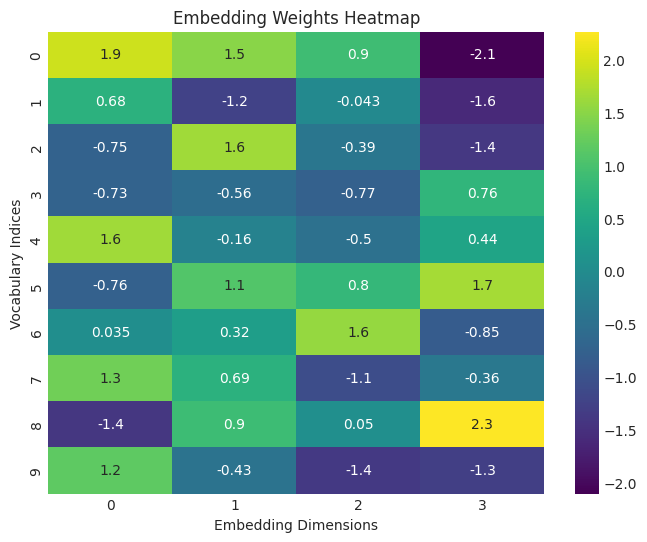

In [6]:
visualize_embeddings(embed_layer.weight, title="Embedding Weights Heatmap")

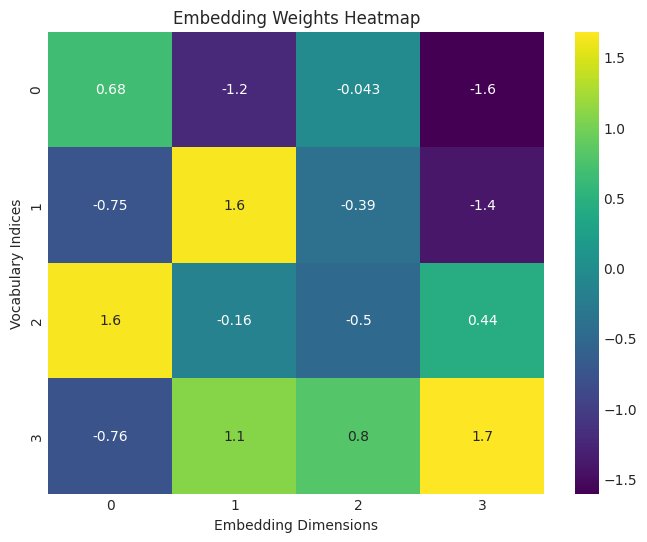

In [8]:
visualize_embeddings(output, title="Embedding Weights Heatmap")

Embeddings are for now randomly initialized, they will be optimized once we go ahead with the training  of the neural network

## 2 Some relevant Parameter for embedding

### Padding Index

In [9]:
padding_idx = 0
embed_layer_with_padding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)

input_indices_with_padding = torch.LongTensor([[0, 2, 0, 5],
                                              [1, 0, 3, 0]])

output_with_padding = embed_layer_with_padding(input_indices_with_padding)

print(f"\nInput indices with padding:\n{input_indices_with_padding}")
print(f"\nEmbeddings with padding:\n{output_with_padding}")


Input indices with padding:
tensor([[0, 2, 0, 5],
        [1, 0, 3, 0]])

Embeddings with padding:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-1.2024,  0.7078, -1.0759,  0.5357],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.1971, -1.1441,  0.3383,  1.6992]],

        [[ 0.3672,  0.1754,  1.3852, -0.4459],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 1.1754,  0.5612, -0.4527, -0.7718],
         [ 0.0000,  0.0000,  0.0000,  0.0000]]], grad_fn=<EmbeddingBackward0>)


In [10]:
loss = output_with_padding.sum()
embed_layer_with_padding.zero_grad()
loss.backward()

print(f"Gradient at padding index ({padding_idx}): {embed_layer_with_padding.weight.grad[padding_idx].sum().item()}")
print(f"Gradient at non-padding index (1): {embed_layer_with_padding.weight.grad[1].sum().item()}")

Gradient at padding index (0): 0.0
Gradient at non-padding index (1): 4.0


### Max Norm Constraint

It is a form of regularization that enforces an absolute upper bound on the magnitude of the weight of the vector. It provides the advantage of not letting the ntework explode because there are too high learning rates.

In [ ]:
#set max_norm for embeddings
max_norm = 1.0
embed_layer_max_norm = nn.Embedding(5, 3, max_norm=max_norm)

#manually create vectors exceeding max_norm
input_indices_max_norm = torch.LongTensor([0, 1, 2, 3, 4])

with torch.no_grad():
    embed_layer_max_norm.weight[0] = torch.tensor([3.0, 4.0, 0.0])  # norm = 5.0
    embed_layer_max_norm.weight[1] = torch.tensor([0.6, 0.8, 0.0])  # norm = 1.0
    embed_layer_max_norm.weight[2] = torch.tensor([1.0, 2.0, 2.0])  # norm = 3.0
    embed_layer_max_norm.weight[3] = torch.tensor([0.0, 0.0, 0.5])  # norm = 0.5
    embed_layer_max_norm.weight[4] = torch.tensor([2.0, 2.0, 1.0])  # norm = 3.0

#Original norms before lookup
print("Original norms with index:")
for i in range(embed_layer_max_norm.num_embeddings):
    norm = embed_layer_max_norm.weight[i].norm().item()
    print(f"Index {i}: Norm = {norm:.4f}")

#Lookup embeddings
output_max_norm = embed_layer_max_norm(input_indices_max_norm)

#Norms after applying max_norm constraint
print("\nNorms after applying max_norm constraint:")
for i in range(embed_layer_max_norm.num_embeddings):
    norm = embed_layer_max_norm.weight[i].norm().item()
    print(f"Index {i}: Norm = {norm:.4f}")

Original norms with index:
Index 0: Norm = 5.0000
Index 1: Norm = 1.0000
Index 2: Norm = 3.0000
Index 3: Norm = 0.5000
Index 4: Norm = 3.0000

Norms after applying max_norm constraint:
Index 0: Norm = 1.0000
Index 1: Norm = 1.0000
Index 2: Norm = 1.0000
Index 3: Norm = 0.5000
Index 4: Norm = 1.0000


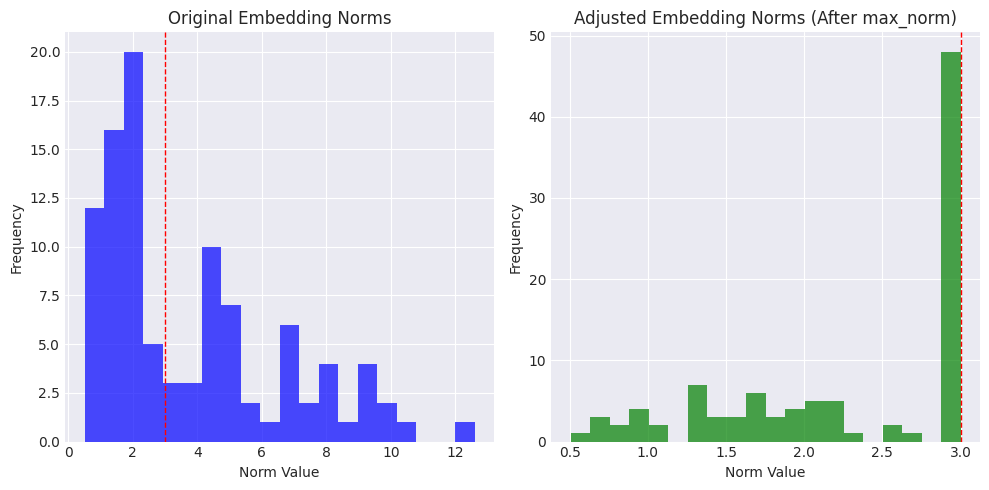

In [17]:
max_norm = 3
vocab_size_large = 100
dimensions = 3
embed_layer_max_norm_3 = nn.Embedding(vocab_size_large, dimensions, max_norm=max_norm)

#create vecotrs that are half of the time excedding max_norm

for i in range(vocab_size_large):
    vec = torch.randn(dimensions) * (1 + (i % 2) * 3)  # Exceed max_norm for odd indices
    with torch.no_grad():
        embed_layer_max_norm_3.weight[i] = vec

#store original norms for histogram
original_norms = [embed_layer_max_norm_3.weight[i].norm().item() for i in range(vocab_size_large)]

#historgram of original norms
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(original_norms, bins=20, color='blue', alpha=0.7)
plt.axvline(max_norm, color='red', linestyle='dashed', linewidth=1)
plt.title('Original Embedding Norms')
plt.xlabel('Norm Value')
plt.ylabel('Frequency')

#Lookup embeddings to enforce max_norm
input_indices_large = torch.LongTensor(list(range(vocab_size_large)))
_ = embed_layer_max_norm_3(input_indices_large)

#store adjusted norms for histogram
adjusted_norms = [embed_layer_max_norm_3.weight[i].norm().item() for i in range(vocab_size_large)]

#historgram of adjusted norms
plt.subplot(1, 2, 2)
plt.hist(adjusted_norms, bins=20, color='green', alpha=0.7)
plt.axvline(max_norm, color='red', linestyle='dashed', linewidth=1)
plt.title('Adjusted Embedding Norms (After max_norm)')
plt.xlabel('Norm Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
                  


### Sparse Gradients

Sparse grandients are a fundamental tool for large vocabolaries because it allows to save a lot in resources 


In [18]:
#large vocab

vocab_size_large = 10000
dimensions= 8
embed_sparse = nn.Embedding(vocab_size_large, dimensions, sparse=True)

sparse_indices = torch.LongTensor([10, 200, 3000, 4000, 5000])
sparse_output = embed_sparse(sparse_indices)

#backward pass
loss_sparse = sparse_output.sum()
embed_sparse.zero_grad()
loss_sparse.backward()

#convert to dense for checking gradients
dense_gradients = embed_sparse.weight.grad.to_dense()
non_zero_grads = (dense_gradients != 0).sum().item()

print(f"Vocabulary size: {vocab_size_large} ")
print(f"Accessed indices: {len(sparse_indices)}")
print(f"Non-zero gradients after backward pass: {non_zero_grads} ")
print(f"Memory efficiency: {non_zero_grads / vocab_size_large * 100:.4f}% of embeddings updated")

Vocabulary size: 10000 
Accessed indices: 5
Non-zero gradients after backward pass: 40 
Memory efficiency: 0.4000% of embeddings updated


In [20]:
print(embed_sparse.weight)
print(embed_sparse.weight.grad)

Parameter containing:
tensor([[ 0.5105, -0.8537, -0.4275,  ...,  0.6367,  0.0925, -0.6212],
        [-0.1488,  0.3166, -1.1287,  ..., -0.0895, -1.4171,  1.8215],
        [-2.1087, -0.0296, -0.8190,  ...,  0.5974,  0.4486,  1.2600],
        ...,
        [ 0.5486, -1.0152, -0.6736,  ..., -0.2918,  0.3307, -0.1876],
        [ 1.0718, -0.9361, -0.1768,  ..., -2.2029,  1.3838,  0.0625],
        [-2.4043, -0.1064,  2.2521,  ...,  0.4914, -1.2746,  0.1346]],
       requires_grad=True)
tensor(indices=tensor([[  10,  200, 3000, 4000, 5000]]),
       values=tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
                      [1., 1., 1., 1., 1., 1., 1., 1.],
                      [1., 1., 1., 1., 1., 1., 1., 1.],
                      [1., 1., 1., 1., 1., 1., 1., 1.],
                      [1., 1., 1., 1., 1., 1., 1., 1.]]),
       size=(10000, 8), nnz=5, layout=torch.sparse_coo)


### Create Embedding from pretrained models

the most important param in this case is the Freeze param. This tells that if you do not want to set it 

In [ ]:
#in this case we are generating random pre-trained weights
pre_trained_weights = torch.randn(100, 50) #100 words, 50 dimensions
pre_trained_weights = torch.nn.functional.normalize(pre_trained_weights, p=2, dim=1)

embed_pretrained = nn.Embedding.from_pretrained(pre_trained_weights, freeze=False)



In [25]:
# create small vocabulary with pad
vocab = ['<PAD>','hello', 'world', 'test', 'embedding', 'pytorch', 'example', 'code', 'AI', 'this', 'is', 'a']

word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

#create embedding layer
vocab_size = len(vocab)
embedding_dim = 8
embed_layer = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

#build sentences from vocab
sentences = [
    'hello world this is a test',
    'hello AI this is embedding example code']

def sentence_to_indices(sentence, word_to_idx):
    return torch.LongTensor([word_to_idx.get(word, 0 ) for word in sentence.split()])

for sentence in sentences:
    input_indices = sentence_to_indices(sentence, word_to_idx)
    embeddings = embed_layer(input_indices)
    print(f"\nSentence: '{sentence}'")
    print(f"Input indices: {input_indices}")
    print(f"Embeddings shape:\n{embeddings.shape}")


Sentence: 'hello world this is a test'
Input indices: tensor([ 1,  2,  9, 10, 11,  3])
Embeddings shape:
torch.Size([6, 8])

Sentence: 'hello AI this is embedding example code'
Input indices: tensor([ 1,  8,  9, 10,  4,  6,  7])
Embeddings shape:
torch.Size([7, 8])


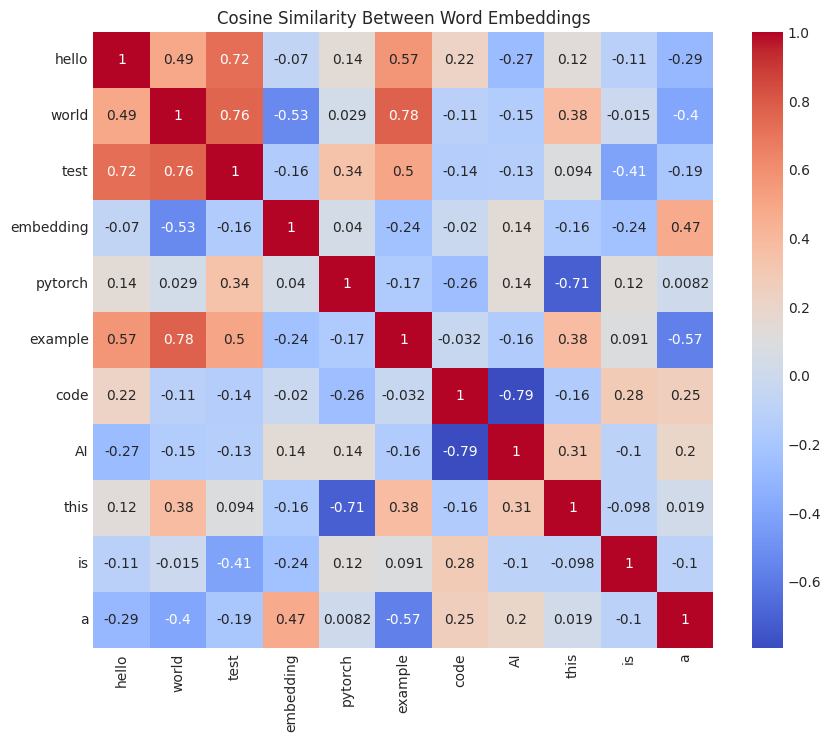

In [26]:
#visualize similarity between senteces

with torch.no_grad():
    #get embeddiings for both senteces
    all_embeddings = embed_layer.weight[1:]  # Exclude padding index

    #compute cosine similarity matrix
    norm_embeddings = torch.nn.functional.normalize(all_embeddings, p=2, dim=1)
    similarity_matrix = torch.mm(norm_embeddings, norm_embeddings.t())

    #plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix.numpy(), xticklabels=vocab[1:], yticklabels=vocab[1:], annot=True, cmap='coolwarm')
    plt.title('Cosine Similarity Between Word Embeddings')
    plt.show()

the values in this matrix are random as of now but when we train a model words with similar meaning will get higher scores